<h1>Analysis of bus public transport in Malaga using graphs</h1>
<h2>Learning from Networks 2022-23</h2>
<p>Project developed by Jesús Moncada Ramírez</p>

<h1>0. Instalation issues</h1>

In order to run successfully this notebook you must have certain versions of some libraries. This have been discovered going into bugs and searching on the internet.
<ul>
  <li>Decorator 5.0.9. Discovered in <a href="https://stackoverflow.com/questions/66920533/networkx-shows-random-state-index-is-incorrect">this link</a>.</li>
    <code>pip3 install decorator==5.0.9</code>
</ul> 

<h1>1. Importing the datasets</h1>

In [121]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_stops = pd.read_csv('dataset/stops.csv', error_bad_lines=False, usecols=['stop_id','stop_code','stop_name','stop_lat','stop_lon'])
df_stop_times = pd.read_csv('dataset/stop_times.csv', error_bad_lines=False)
df_routes = pd.read_csv('dataset/routes.csv', error_bad_lines=False)
df_trips = pd.read_csv('dataset/trips.csv', error_bad_lines=False)
df_shapes = pd.read_csv('dataset/shapes.csv', error_bad_lines=False)
df_lines_stops = pd.read_csv('dataset/lines_and_stops.csv', error_bad_lines=False, usecols=['codLinea', 'userCodLinea', 'nombreLinea', 'sentido', 'orden', 'codParada', 'nombreParada', 'lon', 'lat'])

In order to translate some columns names from spanish to english, we will apply a <code>rename</code> operation over some of the datasets.

In [3]:
rename_dict = {'codLinea':'line_code', 
               'userCodLinea':'line_label',
               'nombreLinea':'line_name',
               'sentido':'line_direction',
               'orden':'stop_order',
               'codParada':'stop_code',
               'nombreParada':'stop_name',
               'lon':'stop_lon',
               'lat':'stop_lat'}

df_lines_stops.rename(columns = rename_dict, inplace=True)

We can also change the data type of somes columns to adjust to our problem.

In [4]:
convert_dict = {'line_code':int, 'line_direction':int}

df_lines_stops = df_lines_stops.astype(convert_dict)

Now we cand describe the CSV files imported to discover info about them.

In [5]:
def describe_dataframe(data_name, data, show=5):
    print("--- {0} ---".format(data_name))
    print("Number of elements: {0}".format(len(data)))
    print(data.head(show))

In [6]:
describe_dataframe('STOPS', df_stops)

--- STOPS ---
Number of elements: 1088
   stop_id  stop_code                      stop_name   stop_lat  stop_lon
0      103        103  Victoria (Plaza de la Merced)  36.723415 -4.416463
1      104        104          Compás de la Victoria  36.727403 -4.413547
2      105        105           Fernando el Católico  36.729034 -4.413708
3      106        106          Cristo de la Epidemia  36.731038 -4.415068
4      107        107        Plaza de Fuente Olletas  36.732988 -4.416382


In [7]:
describe_dataframe('STOP_TIMES', df_stop_times)

--- STOP_TIMES ---
Number of elements: 226398
     trip_id arrival_time departure_time  stop_id  stop_sequence
0  10L7S1V19     24:37:00       24:37:00      755             35
1  10L7S1V19     24:35:00       24:35:00      710             34
2  10L7S1V19     24:34:00       24:34:00      608             33
3  10L7S1V19     24:33:00       24:33:00      709             32
4  10L7S1V19     24:32:00       24:32:00      707             31


In [8]:
describe_dataframe('ROUTES', df_routes)

--- ROUTES ---
Number of elements: 47
   route_id route_short_name  \
0         1                1   
1         2                2   
2         3                3   
3         4                4   
4         5                5   

                                     route_long_name  route_type  \
0    Parque del Sur - Alameda Principal - San Andrés           3   
1                  Alameda Principal - Ciudad Jardín           3   
2  Puerta Blanca - Alameda Principal - El Palo (O...           3   
3  Paseo del Parque - Cruz Humilladero - Cortijo ...           3   
4     Alameda Principal - Guadalmar - Parque de Ocio           3   

                                           route_url  
0  http://www.emtmalaga.es/emt-mobile/informacion...  
1  http://www.emtmalaga.es/emt-mobile/informacion...  
2  http://www.emtmalaga.es/emt-mobile/informacion...  
3  http://www.emtmalaga.es/emt-mobile/informacion...  
4  http://www.emtmalaga.es/emt-mobile/informacion...  


In [9]:
describe_dataframe('TRIPS', df_trips)

--- TRIPS ---
Number of elements: 8391
   route_id service_id  trip_id   trip_headsign  direction_id shape_id
0         1         LN  0L1S1V1      San Andrés             0     1IDA
1         1         LN  0L1S1V2  Parque del Sur             1     1VTA
2         1         LN  0L1S1V3      San Andrés             0     1IDA
3         1         LN  0L1S1V4  Parque del Sur             1     1VTA
4         1         LN  0L1S1V5      San Andrés             0     1IDA


In [10]:
describe_dataframe('SHAPES', df_shapes)

--- SHAPES ---
Number of elements: 24381
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0     1IDA     36.737774     -4.422069                  0
1     1IDA     36.737851     -4.422428                  1
2     1IDA     36.737892     -4.422732                  2
3     1IDA     36.737882     -4.422866                  3
4     1IDA     36.737845     -4.422910                  4


In [11]:
describe_dataframe('LINES_STOPS', df_lines_stops)

--- LINES_STOPS ---
Number of elements: 2328
   line_code line_label                                        line_name  \
0          1          1  Parque del Sur - Alameda Principal - San Andrés   
1          1          1  Parque del Sur - Alameda Principal - San Andrés   
2          1          1  Parque del Sur - Alameda Principal - San Andrés   
3          1          1  Parque del Sur - Alameda Principal - San Andrés   
4          1          1  Parque del Sur - Alameda Principal - San Andrés   

   line_direction  stop_order  stop_code                           stop_name  \
0               1           1        152  Av. de las Postas - Lorenza Correa   
1               1           2        153                         Emilio Díaz   
2               1           3        154            San Juan Bosco - Albéniz   
3               1           4        155          San Juan Bosco - Segalerva   
4               1           5       1354             Eduardo Domínguez Ávila   

   stop_lon   sto

<h1>2. Creating the graph</h2>

As there are several inconsistences in the datasets (e.g. the number of lines in <code>routes.csv</code> is not the same as the number of lines in <code>lines_and_stops.csv</code>) we will use the file <code>lines_and_stops.csv</code> to build the graph, and the rest of files for extra information.

We have to create a directed graph (due to the two directions of the bus lines) with multiple edges between two nodes (because of several bus lines connecting the same two stops).

In [46]:
G = nx.MultiDiGraph()

<h2>2.1. Adding the nodes</h2>

First of all, let's add all the nodes (bus stops). Note we get the stops from the <code>df_lines_stops</code> dataframe, using the dataframe <code>df_stops</code> to get extra information (for example the name, the URL...).

In [47]:
col_target = ['stop_code', 'stop_name', 'stop_lon', 'stop_lat']

# Get all the stops from df_lines_stops
stops = df_lines_stops.drop_duplicates('stop_code')[['stop_code', 'stop_name', 'stop_lon', 'stop_lat']]

describe_dataframe('PROCESSED STOPS', stops)

# Add all stops to the graph
for index, stop in stops.iterrows():
    G.add_node(stop['stop_code'], name=stop['stop_name'], lat=stop['stop_lat'], lon=stop['stop_lon'])

--- PROCESSED STOPS ---
Number of elements: 1116
   stop_code                           stop_name  stop_lon   stop_lat
0        152  Av. de las Postas - Lorenza Correa -4.422251  36.737835
1        153                         Emilio Díaz -4.423585  36.735730
2        154            San Juan Bosco - Albéniz -4.422321  36.734028
3        155          San Juan Bosco - Segalerva -4.421849  36.732384
4       1354             Eduardo Domínguez Ávila -4.421500  36.730183


<h2>2.2 Adding the edges</h2>

First, note that every line has an identifier <code>line_code</code> that we will use to identify the lines in our data structures, and a label <code>line_label</code>, which is the formal name of the line, known by every people using the public transport. Let's create a dictionary relating every <code>line_code</code> with its <code>line_label</code>.

In [48]:
unique_lines = df_lines_stops['line_code'].unique()

line_code_label_dict = {}

for line in unique_lines:
    line_code_label_dict[line] = df_lines_stops.loc[df_lines_stops["line_code"] == line].iloc[0]["line_label"]

print(line_code_label_dict)

{1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 14: '14', 15: '15', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 25: '25', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 40: '40', 62: '62', 91: '91', 92: '92', 93: '93', 75: 'A', 71: 'C1', 72: 'C2', 73: 'C3', 76: 'C6', 78: 'C8', 70: 'E', 65: 'L', 41: 'N1', 42: 'N2', 43: 'N3', 44: 'N4', 45: 'N5'}


For example, the line known as C1 (label) has the code 71.

In order to add the edges, we must think of a measure of the connection <b>quality</b> between two stops. It will be an edge attribute (allowed by the library NetworkX) and will be called <code>velocity</code>. If an edge between two stops has a high <code>velocity</code>, it means that the waiting time to get from one stop (origin of the edge) to the other (destination of the edge) is going to be low. In this project we will consider that the <code>velocity</code> attribute for an edge depends on:
<ul>
    <li><b>Distance between stops</b> (inversely proportional): can be computed as the distance between points given as (latitude, longitude). <i>Notation</i>: distance between stop $s_1$ and stop $s_2$ is: $d(s_1, s_2)$</li>
    <li><b>Number of buses of that lines in a time interval</b> (directly proportional): the dataset <code>trips.csv</code> provided us with information about this. They don't specify exactly the time interval (dayly, weekly) of all the trips listed, but this doesn't really matter to us, as we need a high value if a line has high frequency and a low value otherwise. <i>Notation</i>: number of buses of an edge $e$ beloging to a bus line $l$ is $n(l)$</li>
</ul> 
Based on this we define the <code>velocity</code> of an edge $e$, as:
$$
v(e) = v((s_1, s_2)) = I_v \cdot \frac{n(l)}{d(s_1, s_2)}
$$
where $I_v$ is a constant that modulates the importance of the two factors we are considering (number of buses and geographical distance). In this implementation we are going to consider $I_v = \frac{1}{1000}$.

In [49]:
I_V = 1/1000

def distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def number_buses(line):
    n_buses = len(df_trips.loc[df_trips['route_id'] == line])
    return n_buses if n_buses > 0 else 1

def get_velocity(line, s1, s2):
    vel = I_V * float(number_buses(line)) / (distance(s1['stop_lat'], s1['stop_lon'], s2['stop_lat'], s2['stop_lon']))
    return vel

Note that there is no data of the trips for every bus line (for example line with <code>line_id</code> 91). As we have defined the velocity of an edge, if this happens it would have velocity equal to 0. We don't want this, so if the number of buses returned by our fuction was 0 it returns 1.

Now we're ready to add all edges to our graph.

In [50]:
for line in unique_lines:
    for direction in [1, 2]:
        
        #print("line {0}; direction {1}".format(line, direction))
        data = (df_lines_stops.loc[(df_lines_stops['line_code'] == line) &
                                 (df_lines_stops['line_direction'] == direction)])
        
        #Saving steps to retrieve (lat, lon) of stops
        previous_step = None
        actual_step = None
        
        for index, step in data.iterrows():
            previous_step = actual_step
            actual_step = step
            
            if previous_step is not None and actual_step is not None:                
                vel = get_velocity(line, previous_step, actual_step)
                G.add_edge(previous_step['stop_code'], actual_step['stop_code'], line=int(line), direction=int(direction), velocity=vel)

print("The graph has {0} edges".format(len(G.edges())))

The graph has 2236 edges


<h3>2.2.1. Analyzing velocities</h3>

Now we should analyze the velocities to discover the range of values that they take.

In [51]:
def stats_velocities(G):
    velocities = []

    for _, _, data in G.edges(data=True):
        velocities.append(data['velocity'])

    #print(velocities)
    vel_min = min(velocities)
    vel_max = max(velocities)
    vel_mean = np.mean(velocities)
    vel_std = np.std(velocities)

    print('Stats')
    print('Number of values:', len(velocities))
    print('Minimum value:', vel_min)
    print('Maximum value:', vel_max)
    print('Mean:', vel_mean)
    print('Standard deviation:', vel_std)
    
    return velocities

In [52]:
vels = stats_velocities(G)

Stats
Number of values: 2236
Minimum value: 0.01989299444260319
Maximum value: 778.6867146145279
Mean: 70.95989163774544
Standard deviation: 73.17717189732548


As we can appreciate, the difference between the maximum value and the mean is very high. This happens because there are several stops of the same line that are geographically very close. We are going to apply a <b>saturation</b> at the value of 300. 

In [53]:
THRESHOLD = 300

for _, _, data in G.edges(data=True):
    if data['velocity'] >= THRESHOLD:
        data['velocity'] = THRESHOLD

In [54]:
vels = stats_velocities(G);

Stats
Number of values: 2236
Minimum value: 0.01989299444260319
Maximum value: 300
Mean: 70.19246172224311
Standard deviation: 69.57246045077508


Now we are going to <b>normalize</b> the values (against the maximum), forcing them to take values in the interval $[0,1]$.

In [55]:
for _, _, data in G.edges(data=True):
    data['velocity'] = float(data['velocity'])/max(vels)

Now the stats for the edge attribute <code>velocity</code> are:

In [56]:
vels = stats_velocities(G);

Stats
Number of values: 2236
Minimum value: 6.630998147534397e-05
Maximum value: 1.0
Mean: 0.23397487240747705
Standard deviation: 0.2319082015025836


<h2>2.3. Displaying it graphically</h2>

First of all we will have to assign a color to each node (stop) and edge (connection between stops) in the graph. The color of a stop will be black, and won't depend on the lines, as a stop can belong to several bus lines. Said this, we have two option to set the edge color.

The first thing we have to do is creating a dictionary with the position of every node, <code>positions</code>.

In [57]:
positions = {}

for stop_line, data in G.nodes(data=True):
    positions[stop_line] = [data['lon'], data['lat']]

<h3>2.3.1. Velocity-based edge color</h3>

One option is to show with a more visible color those edges with a high velocity value. Those edges with a low velocity value will have a almost white color, in this way we get the gray scale in our graph drawing.

In [58]:
edge_color_vel = []

for u, v, data in G.edges(data=True):
    edge_color_vel.append([1-data['velocity'],1-data['velocity'],1-data['velocity']])

To display all nodes in the graph we execute:

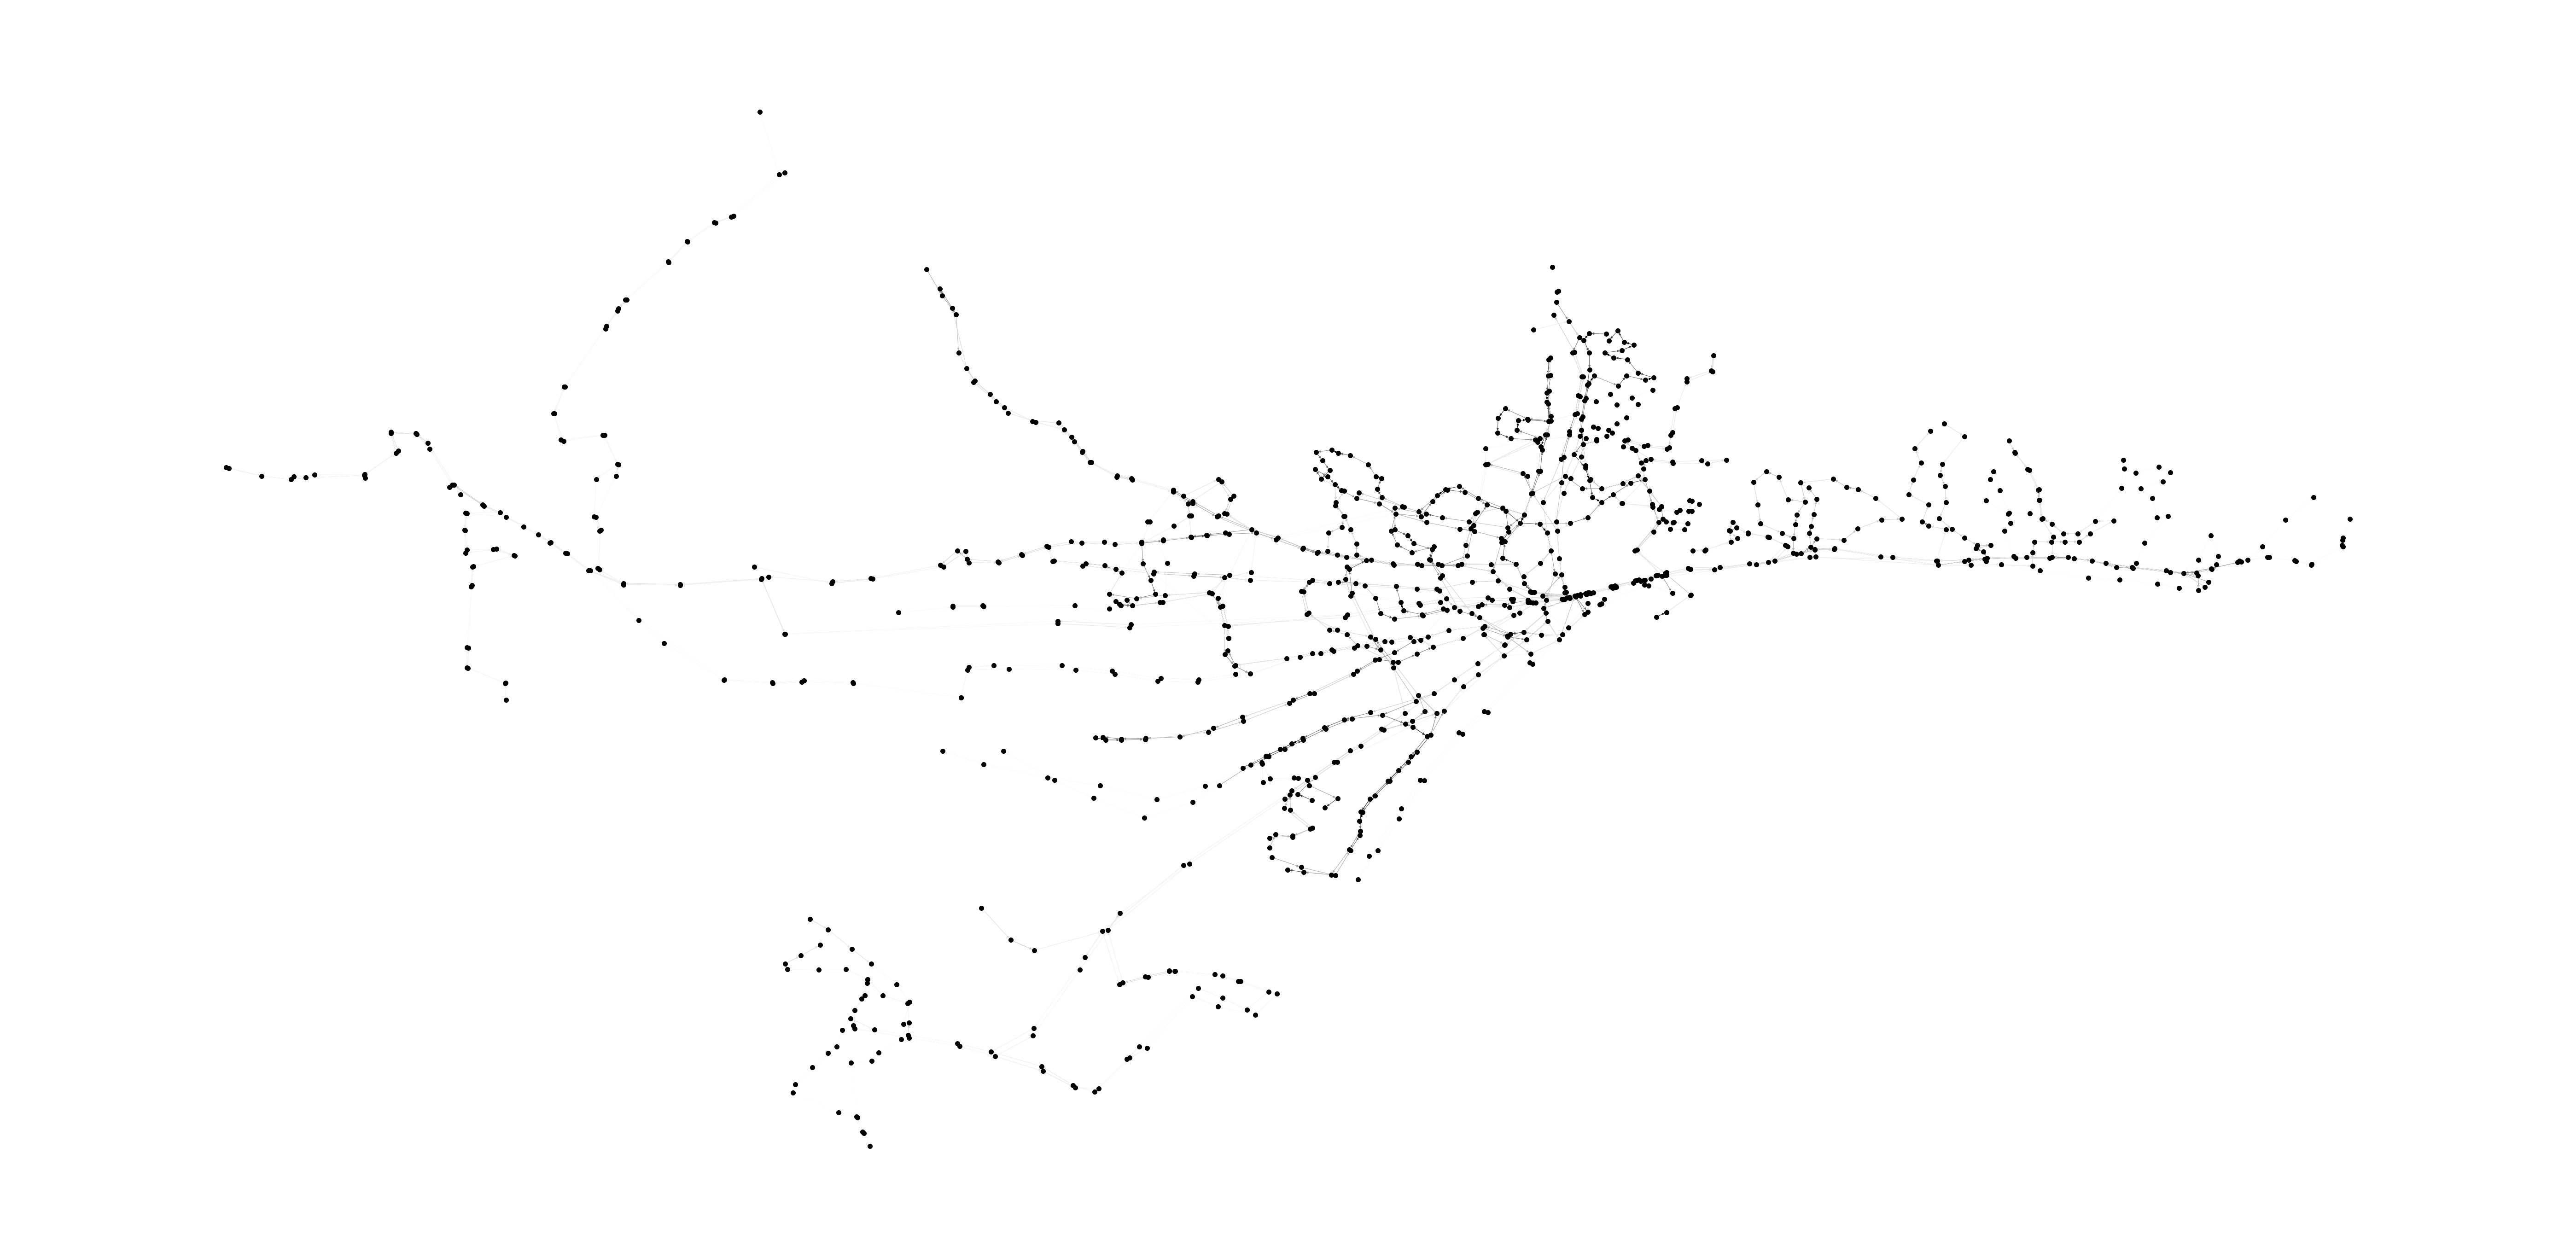

In [59]:
fig, ax = plt.subplots(figsize = (100,50))

nx.draw(G,
        pos         = positions,
        node_color = 'black',
        edge_color = edge_color_vel,
        font_size   = 10,
        node_size   = 100)

fig.savefig("drawings/velocity_based.png")

<h3>2.3.2. Line-based edge color</h3>

Other option consists in each line having a color, so the edges belonging to this line will be all of the same color. These colors are chosen at random.

In [60]:
line_color_dict = {}

for line in unique_lines:
    line_color_dict[line] = tuple(np.random.random(3))
    
edge_color_ln = []

for u, v, data in G.edges(data=True):
    edge_color_ln.append(line_color_dict[data['line']])

To display all the nodes in the graph we execute:

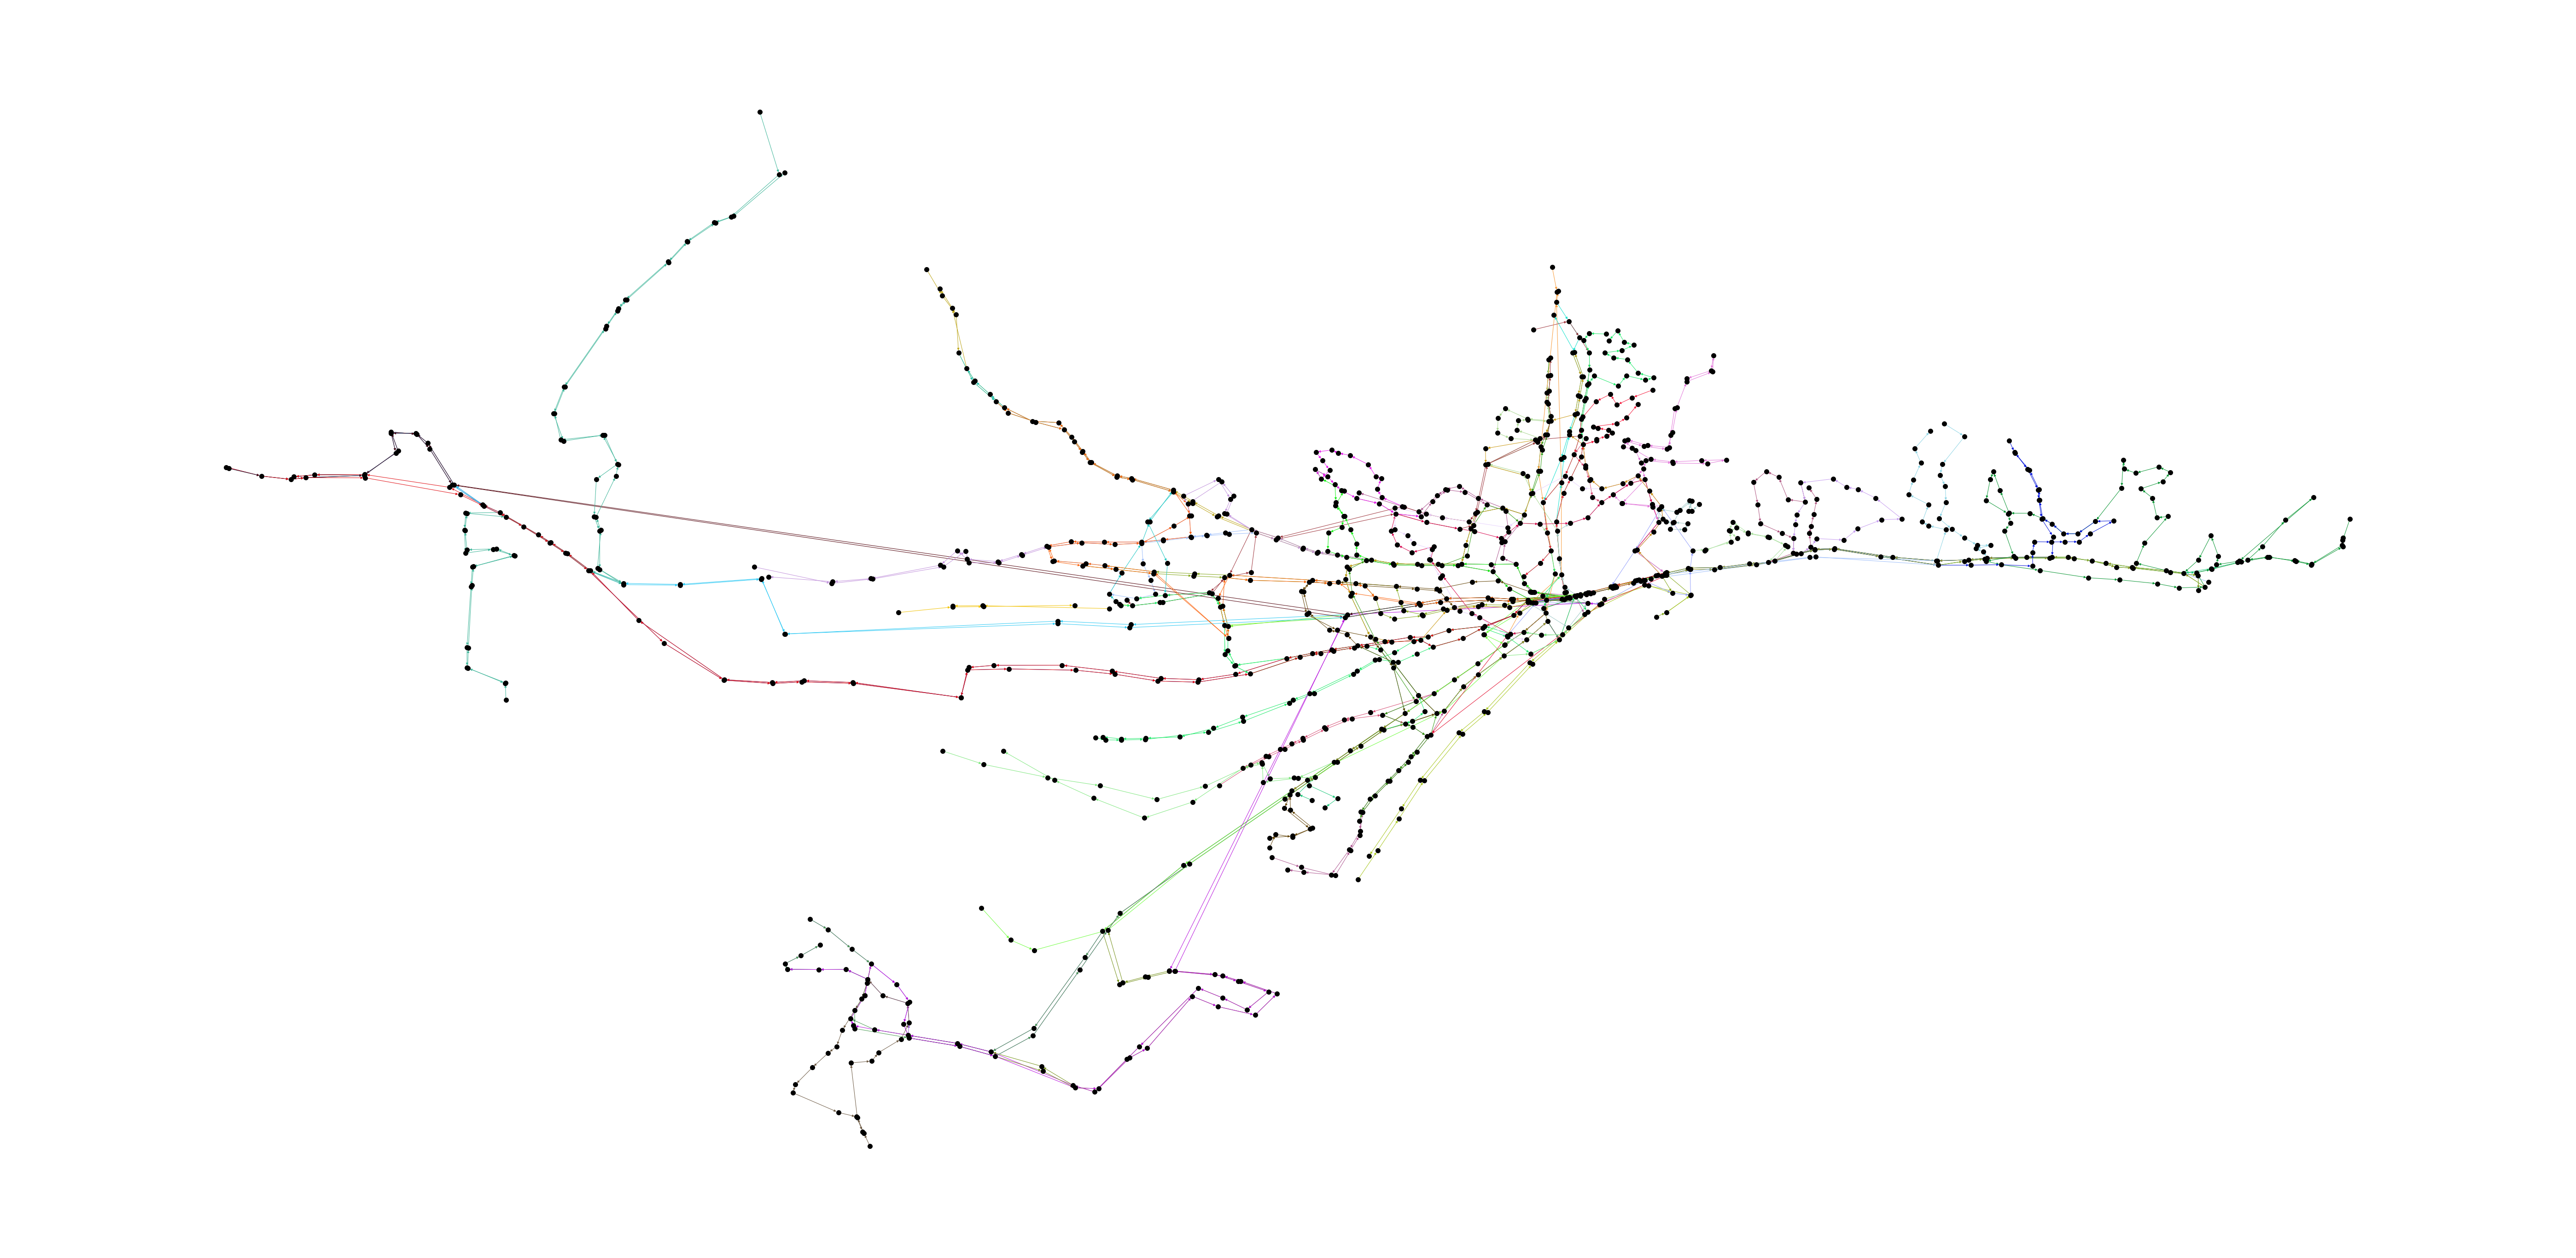

In [61]:
fig, ax = plt.subplots(figsize = (100,50))

nx.draw(G,
        pos         = positions,
        node_color = 'black',
        edge_color = edge_color_ln,
        font_size   = 10,
        node_size   = 100)

fig.savefig("drawings/line_based.png")

<h3>2.3.3. Using Mplleaflet (optional)</h3>

The Python library Mplleaflet allows to show Matplotlib drawings on an interactive map based on Open Street Map or other map services. The result is a webpage, which can be embedded into an Jupyter notebook.

Unfortunately, there are bugs in the library that haven't been solved yet, like <a href="https://stackoverflow.com/questions/60603427/problems-plotting-on-mplleaflet-using-networkx-and-python">this one</a> that I encountered during the development of the project. To solve it I had to downgrade <code>matplotlib</code> to version 3.3.2 (<a href="https://lightrun.com/answers/jwass-mplleaflet-_gridonmajor-bug-with-recent-versions-of-matplotlib">following this link</a>) and edit the source code of the <code>Mplleaflet</code> library. Specifically, the file <code>mplleaflet/utils.py</code> substituting the line:

<code>elif code == 'L':</code>

by:

<code>elif code == 'L' or code == 'S' or code == 'Z':</code>

Even so, the results aren't as good as expected. Executing the cells of code below you can observe that the edges of the graph appear lightly moved to their original position (in the previous image). Because of that, after watching the results, this section has been classified as optional, like an extended feature that can be computed to test.

In [28]:
#import mplleaflet

In [29]:
#mplleaflet.show(fig = ax.figure, path='drawings/generated_map.html')

The map generated will also be saved into a file for posterior visualization (<code>generated_map.html</code>). 

<h1>3. Node centralities</h1>

The first part of our analysis will be the computation of some node centralities for nodes (stops). 

In this section we are going to create another version of our graph (<code>G_closeness</code>) with only one difference: instead of having the value of <code>velocity</code> we will have its inverse, and will be called <code>distance</code>. With this, if an edge had a high <code>velocity</code> value, it means that it was very fast, so its <code>distance</code> will be low (inverse). The same for the opposite case.

In [62]:
def velocity_to_distance(G):
    # Copy the graph
    G_ret = G.copy()

    # Change 'velocity' attribute to 'distance' as we have explained
    for _, _, data in G_ret.edges(data=True):
        data['distance'] = 1/data['velocity'] # calculate distance
        data.pop('velocity') # delete velocity
        
    return G_ret

# Copy the graph
G_closeness = velocity_to_distance(G)
    
print("The graph has {0} edges".format(len(G_closeness.edges())))

The graph has 2236 edges


<h2>3.1. Closeness centrality</h2>

In this section we will consider two versions of closeness centrality. The first one does not take into account the <code>distance</code> attribute of each edge we have calculated, so supposes that each edge is weighted with a value of 1. The second version takes into account this attribute. We will report the best and worst nodes related to this centrality and compare them.

<h3>3.1.1. Without considering <code>distance</code></h3>

The NetworkX library implements a method to calculate closeness centralities: <code>networkx.closeness_centrality(...)</code>. The documentation can be found [here](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.closeness_centrality.html).

In [63]:
cn_cen = nx.closeness_centrality(G_closeness)
#print(cn_cen)

In [64]:
best_node = max(cn_cen, key=cn_cen.get)

print('The node with the highest CLOSENESS CENTRALITY is', best_node)
print(df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest CLOSENESS CENTRALITY is 164
    stop_id  stop_code         stop_name   stop_lat  stop_lon
25      164        164  Paseo del Parque  36.719527 -4.416269


As we expected, the stop with the <b>highest closeness centrality</b> value is located in the city centre. "Paseo del Parque" avenue in Malaga is one of the busiest and has connections with most of the city's bus lines.

As we can observe there are several nodes with closeness centrality equals to 0. Let's visualize them.

In [65]:
worst_nodes = []
for stop_id in cn_cen:
    if cn_cen[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest CLOSENESS CENTRALITY are (showing only 5): ')
for stop_id in worst_nodes[0:5]:
    print(df_stops.loc[df_stops['stop_id'] == stop_id][['stop_id', 'stop_name']]) #show only id and name

The node with the lowest CLOSENESS CENTRALITY are (showing only 5): 
    stop_id                             stop_name
14      152  Avda. de las Postas (Lorenza Correa)
    stop_id         stop_name
28      172  Hermanos Lumiere
    stop_id   stop_name
41      229  Atarazanas
    stop_id                       stop_name
76      351  Puerta Blanca (Gregorio Diego)
     stop_id                     stop_name
372     1151  Carretera de Olías (El Palo)


Analyzing the stops with <b>lowest closeness centrality</b> we have discorered that they are located in remote parts of the city, and they are usually the first/last stops of a line. For example the stop 152 (<i>Avda. de las Postas (Lorenza Correa)</i>) is the first/last of line 1; and the stop 351 (<i>Puerta Blanca (Gregorio Diego)</i>) is the first/last of line 3.

<h3>3.1.2. Considering <code>distance</code></h3>

In [66]:
cn_cen_distance = nx.closeness_centrality(G_closeness, distance='distance')
#print(cn_cen_distance)

In [67]:
best_node = max(cn_cen_distance, key=cn_cen_distance.get)

print('The node with the highest CLOSENESS CENTRALITY is', best_node)
print(df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest CLOSENESS CENTRALITY is 1359
     stop_id  stop_code                                   stop_name  \
417     1359       1359  Paseo de la Farola (Comandancia de Marina)   

      stop_lat  stop_lon  
417  36.717816 -4.412449  


In [68]:
worst_nodes = []
for stop_id in cn_cen_distance:
    if cn_cen_distance[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest CLOSENESS CENTRALITY are (showing only 5): ')
for stop_id in worst_nodes[0:5]:
    print(df_stops.loc[df_stops['stop_id'] == stop_id][['stop_id', 'stop_name']]) #show only id and name

The node with the lowest CLOSENESS CENTRALITY are (showing only 5): 
    stop_id                             stop_name
14      152  Avda. de las Postas (Lorenza Correa)
    stop_id         stop_name
28      172  Hermanos Lumiere
    stop_id   stop_name
41      229  Atarazanas
    stop_id                       stop_name
76      351  Puerta Blanca (Gregorio Diego)
     stop_id                     stop_name
372     1151  Carretera de Olías (El Palo)


As we can observe, the stop with the highest closeness centrality changes, now it is the stop 417 (<i>Paseo de la Farola (Comandancia de Marina)</i>). This stop is not an important one as it provides only lines 14, 40 and 92; but it is the more central one, because is located in the city centre, in the middle of the west and east part of Málaga.

<h2>3.2. Betweenness centrality</h2>

Unfortunally, the betweeennes centrality is not implemented for multi-directed graphs in the library we are using. The only solution we have come up with is creating a different version (called <code>G_betweenness</code>) using a directed graph (no multiple edges between nodes). In this way all the edges that were present between two nodes will be substituted by only one. The new <code>velocity</code>  of this edge will be the maximum of the previous one. The <code>line</code> attribute will be <code>-1</code> and the <code>direction</code> attribute will also be -1, as they don't provide now usefull information.

In [69]:
def multidi_to_di_max(G):
    G_result = nx.DiGraph()

    for u, v, _ in G.edges(data=True):
        # if this edge has not been added to the new graph yet
        if not G_result.has_edge(u, v):
            line = -1
            direction = -1
            velocity = 0.0
            for um, vm, datam in G.edges(data=True):
                if datam['velocity'] > velocity:
                    velocity = datam['velocity']

            G_result.add_edge(u, v, line=line, direction=direction, velocity=velocity)
    
    return G_result

G_betweenness = multidi_to_di_max(G)
G_betweenness = velocity_to_distance(G_betweenness)    
    
print("The graph has {0} edges".format(len(G_betweenness.edges())))

The graph has 1277 edges


As before we will consider a version without having into account the <code>distance</code> attribute and another one that considers it.

<h3>3.2.1. Without considering <code>distance</code></h3> 

In [70]:
bn_cen = nx.betweenness_centrality(G_betweenness, seed=1)
#print(cn_cen)

In [71]:
best_node = max(bn_cen, key=bn_cen.get)

print('The node with the highest BETWEENNESS CENTRALITY is', best_node)
print(df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest BETWEENNESS CENTRALITY is 662
     stop_id  stop_code           stop_name  stop_lat  stop_lon
171      662        662  Avda. de Andalucía   36.7164 -4.428264


The stop with <b>highest betweenness centrality</b> has id 662 (<i>Avda. de Andalucía</i>). This makes sense, because lines 4, 7, 8, 14, 19, 21, 23, 38, 92, A, N2 and N3 go thorugh this stop. This information was obtained by looking for this stop in the EMT app, but can also be obtained with our code.

In [75]:
def lines_of_stop(stop_id, G):
    lines = set()
    
    for s1, s2, data in G.edges(data=True):
        if stop_id == s1 or stop_id == s2:
            lines.add(data['line'])
            
    return list(lines)

linecodes_662 = lines_of_stop(662, G)
print('Line codes of stop 662:', linecodes_662)

linelabels_662 = []
for code in linecodes_662:
    linelabels_662.append(line_code_label_dict[code])
                                               
print('Line labels of stop 662:', linelabels_662)

Line codes of stop 662: [4, 38, 7, 8, 42, 43, 75, 14, 19, 21, 23, 92]
Line labels of stop 662: ['4', '38', '7', '8', 'N2', 'N3', 'A', '14', '19', '21', '23', '92']


In [76]:
worst_nodes = []
for stop_id in bn_cen:
    if bn_cen[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): ')
for stop_id in worst_nodes[0:5]:
    print(df_stops.loc[df_stops['stop_id'] == stop_id][['stop_id', 'stop_name']]) #show only id and name

The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): 
    stop_id                             stop_name
14      152  Avda. de las Postas (Lorenza Correa)
Empty DataFrame
Columns: [stop_id, stop_name]
Index: []
     stop_id                  stop_name
922     3264  Alameda Principal (Norte)
    stop_id         stop_name
28      172  Hermanos Lumiere
    stop_id   stop_name
41      229  Atarazanas


Again, the stops with the <b>lowest betweenness centrality</b> are those at the begining/end of a line, which is what we expected.

<h3>3.2.2. Considering <code>distance</code></h3>

In [77]:
bn_cen_distance = nx.betweenness_centrality(G_betweenness, seed=1, weight='distance')
#print(cn_cen)

In [78]:
best_node = max(bn_cen_distance, key=bn_cen_distance.get)

print('The node with the highest BETWEENNESS CENTRALITY is', best_node)
print(df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest BETWEENNESS CENTRALITY is 662
     stop_id  stop_code           stop_name  stop_lat  stop_lon
171      662        662  Avda. de Andalucía   36.7164 -4.428264


In [79]:
worst_nodes = []
for stop_id in bn_cen:
    if bn_cen_distance[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): ')
for stop_id in worst_nodes[0:5]:
    print(df_stops.loc[df_stops['stop_id'] == stop_id][['stop_id', 'stop_name']]) #show only id and name

The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): 
    stop_id                             stop_name
14      152  Avda. de las Postas (Lorenza Correa)
Empty DataFrame
Columns: [stop_id, stop_name]
Index: []
     stop_id                  stop_name
922     3264  Alameda Principal (Norte)
    stop_id         stop_name
28      172  Hermanos Lumiere
    stop_id   stop_name
41      229  Atarazanas


As we can observe, the results are very similar to those obtained without considering the <code>distance</code> attribute.

<h1>4. Random graphs</h1>

In this section we will generate some random graphs with the same number of nodes of our original graph and calculate closeness centrality and betweenness centrality on them. After all the results will be analyzed to see if the measures we got in the previous section are significant or not. In this section we will forget about the edge weights (like <code>velocity</code> or <code>distance</code>) because we have seen the results are very similar using them or not. We will also forget about the multiple edges between nodes to simplify the process.

In [99]:
def delete_edge_attributes(G, att_list):
    G_result = G.copy()
    
    for _, _, data in G.edges(data=True):
        for att in att_list:
            data.pop(att, None)
    
    return G_result

In [100]:
G_random = multidi_to_di_max(G)
G_random = delete_edge_attributes(G_random, ['velocity', 'line', 'lat', 'lon'])

print("The graph has {0} edges".format(len(G_random.edges())))

The graph has 1277 edges


<h2>4.1. Chung-Lu model</h2>

In this section we will:
- Calculate the closeness centrality and betweenness centrality for all nodes in the new version of our graph <code>G_random</code>.
- Generate a constant number (<code>N_RANDOM_GRAPHS</code>) of graphs following the Chung-Lu model.
- Calculate the closeness centrality and betweenness centrality for all nodes in these graphs.
- Compare results to see if the results for the original graph are significant.

In [108]:
# Closeness centrality for the original graph
chunglu_cc_original = nx.closeness_centrality(G_random)

# Betweenness centrality for the original graph
chunglu_bc_original = nx.betweenness_centrality(G_random)

In [111]:
# Number of random graphs to be generated
N_RANDOM_GRAPHS = 50

# Get degree sequence for original graph
original_deg_sequence = [d for n, d in G_random.degree()]

# List of random graphs generated with the Chung-Lu model
random_graphs = []

# Generate those random graphs
for i in range(N_RANDOM_GRAPHS):
    new_graph = nx.expected_degree_graph(original_deg_sequence, seed=i, selfloops=False)
    random_graphs.append(new_graph)

In [112]:
# List with the closeness centrality result for every random graph.
chunglu_ccs = [nx.closeness_centrality(graph) for graph in random_graphs]
print("Calculated all {0} closeness centralities of random graphs".format(len(chunglu_ccs)))

# List with the betweenness centrality result for every random graph.
chunglu_bcs = [nx.betweenness_centrality(graph) for graph in random_graphs]
print("Calculated all {0} betweeness centralities of random graphs".format(len(chunglu_bcs)))

Calculated all 50 closeness centralities of random graphs
Calculated all 50 betweeness centralities of random graphs


In [134]:
chunglu_cc_zvalues = []

for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_cc_original[node]
    
    expectation = np.mean([cc[i] for cc in chunglu_ccs])
    std = np.std([cc[i] for cc in chunglu_ccs])
    
    zscore = (real_value - expectation) / std
    
    chunglu_cc_zvalues.append(zscore)
    
chunglu_bc_zvalues = []

for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_bc_original[node]
    
    expectation = np.mean([bc[i] for bc in chunglu_bcs])
    std = np.std([bc[i] for bc in chunglu_bcs])
    
    zscore = (real_value - expectation) / std
    
    chunglu_bc_zvalues.append(zscore)